In [162]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from openpyxl import Workbook
from openpyxl import load_workbook
import re
from itertools import chain
from sklearn.utils import shuffle
import nltk  
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [73]:
def load_romanian_data():
    wb = load_workbook('../articole.xlsx')
    sheet = wb['Foaie1']
    data_pos=[]
    data_neg=[]
    data_doubt=[]
    value = ''
    for i in range(1, len(sheet['B'])):
        value = str(sheet['B' + str(i)].value).replace('•', '') # remove special characters
        if bool(re.match('^(?=.*[a-zA-Z])', str(sheet['B' + str(i)].value))): # check if string not empty and has letters
            if sheet['A' + str(i)].value == 1:
                data_pos.append(value)
            elif sheet['A' + str(i)].value == 0:
                data_doubt.append(value)
            elif not sheet['A' + str(i)].value:
                data_neg.append(value)
    print("data pos len: " + str(len(data_pos)))
    print( "data neg len: " + str(len(data_neg)))
    
#     low_limit = 3000
#     high_limit = 10000
#     test_pos = data_pos[:low_limit]
#     train_pos = data_pos[low_limit:high_limit]
#     test_neg = data_neg[:low_limit]
    limit = 2400
    test_pos = data_pos[:limit]
    test_neg = data_neg[:limit]
#     train_pos = data_pos[limit:]
#     train_neg = data_neg[limit:len(data_pos)] # we make sure len of neg data = len of pos data(len neg > len pos initially)

#     train_pos = [str(w).lower() for w in train_pos]
#     train_pos = ([" ".join(j for j in w.split() if len(j) >= 2) for w in train_pos])

#     train_neg = [str(w).lower() for w in train_neg]
#     train_neg = ([" ".join(j for j in w.split() if len(j) >= 2) for w in train_neg])

    with open("data/lemma/train_pos_lemma.txt") as pos_lemma:
        train_pos_lemma = pos_lemma.readlines()
    train_pos_lemma = ([" ".join(j for j in w.split() if len(j) >= 2) for w in train_pos_lemma])
    with open("data/lemma/train_neg_lemma.txt") as neg_lemma:
        train_neg_lemma = neg_lemma.readlines()
    train_neg_lemma = ([" ".join(j for j in w.split() if len(j) >= 2) for w in train_neg_lemma])
    
    test_pos = [str(w).lower() for w in test_pos]
    test_neg = [str(w).lower() for w in test_neg]
    
    return train_pos_lemma, train_neg_lemma, test_pos, test_neg

In [74]:
def prepare_train_and_test(train_pos, train_neg, test_pos, test_neg):
    X_train = list(chain(train_pos, train_neg))
    y_train = np.concatenate((np.ones(len(train_pos), int), np.zeros(len(train_neg), int)))

    X_test = list(chain(test_pos, test_neg))
    y_test = np.concatenate((np.ones(len(test_pos), int), np.zeros(len(test_neg), int)))

    X_train_shuffled, y_train_shuffled =  shuffle(X_train, y_train)
    X_test_shuffled, y_test_shuffled = shuffle(X_test, y_test)

    return X_train_shuffled, y_train_shuffled, X_test_shuffled, y_test_shuffled

In [75]:
def remove_stopwords(sentences_list, updated_stopwords):
    filtered_sentence = []
    for sentence in sentences_list:
        filtered_sentence.append([w for w in sentence if not w in updated_stopwords])
    return repair_sentence(filtered_sentence)


def remove_punctuation(from_train_data):
    table = str.maketrans('', '', string.punctuation)
    no_punctuation = [w.translate(table) for w in from_train_data]
    numbers = re.compile('[0-9]')
    plain_text = [numbers.sub("", word) for word in no_punctuation]
    return plain_text
    

def remove_spaces(from_train_data):
    clean_spaces_data = []
    for sentence in from_train_data:
        clean_spaces_data.append(re.sub(' +', ' ', sentence).rstrip().lstrip())
    return clean_spaces_data

def repair_sentence(sentence_list):
    return [' '.join(map(str, element)) for element in sentence_list]


def update_stopwords(stopwords):
    do_no_remove_these_sw = ['not', 'no', 'can','has','have','had','must','shan','do', 'should','was','were','won',
                             'are','cannot','does','ain', 'could', 'did', 'is', 'might', 'need', 'would']
    return [word for word in stopwords if word not in do_no_remove_these_sw]


def stem_words(from_text):
    stemmer = SnowballStemmer("romanian")
    stemmer2 = SnowballStemmer("romanian", ignore_stopwords=True)
    return [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in from_text]


def lemmatize_words(sentence):
    from pywsd.utils import lemmatize_sentence
    return lemmatize_sentence(sentence)


def sentence_tokenization(sentence):
    return word_tokenize(sentence)


def sentence_punct_tokenization(sentence):
    return WordPunctTokenizer().tokenize(sentence)


def sentence_split_tokenization(sentence):
    return ([i for i in re.split(' ', sentence) if i])


def remove_apostrophe_words(train):
    train = [w.replace("it's", 'it is')
                     .replace("that's", "that is")
                     .replace("it 's", 'it is')
                     .replace("that 's", "that is")
                     .replace("'ve", " have")
                     .replace("' ve", " have")
                     .replace("won't", "will not")
                     .replace("wo n't", "will not")
                     .replace("don't", "do not")
                     .replace("do n't", "do not")
                     .replace("can't", "can not")
                     .replace("ca n't", "can not")
                     .replace("sha n't", "shall not")
                     .replace("shan't", "shall not")
                     .replace("n't", " not")
                     .replace("'re", " are")
                     .replace("'d", " would")
                     .replace("'ll", " will") for w in train]
    return train

def remove_empty_sentences(X, y):
    new_X = []
    new_y = []
    for i in range(len(X)):
        if len(X[i].split()) > 1:
            new_X.append(X[i])
            new_y.append(y[i])
    return new_X, new_y

In [76]:
def feature(X_train):
    stopwords = set(nltk.corpus.stopwords.words('romanian'))
    
    tokenized_sentence = []
    for sentence in X_train:
        tokenized_sentence.append(sentence_punct_tokenization(sentence))

    # NO STOP WORDS
    train_without_stopwords = remove_stopwords(tokenized_sentence, stopwords)

    # NO PUNCTUATION
    train_without_punctuation = remove_punctuation(train_without_stopwords)
    train_clean_spaces = remove_spaces(train_without_punctuation)
    return train_clean_spaces # we choose to extract stop words

# Main

In [77]:
from sklearn import svm

In [78]:
train_pos, train_neg, test_pos, test_neg = load_romanian_data()

data pos len: 11077
data neg len: 23509


In [79]:
X_train, y_train, X_test, y_test = prepare_train_and_test(train_pos, train_neg, test_pos, test_neg)

In [80]:
feat_train = feature(X_train)

In [81]:
svd = TruncatedSVD(n_components=80, random_state=13)
svm_clf = svm.SVC(gamma='scale')

Character bigrams

In [169]:
char_bigram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2, 2))
# counts = ngram_vectorizer.fit_transform(['words', 'wprds'])
X_train_char_bigrams = char_bigram_vectorizer.fit_transform(X_train)
X_test_char_bigrams = char_bigram_vectorizer.fit_transform(X_test)
# ngram_vectorizer.get_feature_names() == (
#     [' w', 'ds', 'or', 'pr', 'rd', 's ', 'wo', 'wp']

In [170]:
# Fit the LSI model and perform dimensionality reduction
X_train_char_bigrams_reduced = svd.fit_transform(X_train_char_bigrams)
X_test_char_bigrams_reduced = svd.fit_transform(X_test_char_bigrams)

In [171]:
# 4. Support Vector Machine
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train_char_bigrams_reduced, y_train)

predicted_test = svm_clf.predict(X_test_char_bigrams_reduced)
predicted_train = svm_clf.predict(X_train_char_bigrams_reduced)

print('========== Character 2-grams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== Character 2-grams (SVM) ==========
The F-1 score for test query is 0.7057252282262025
Training accuracy of SVM model is 0.7214179870055853
Test accuracy of SVM model is 0.7058333333333333



-----------------------------------------------------------------------------------------------------------
Roc auc:  0.7058333333333333


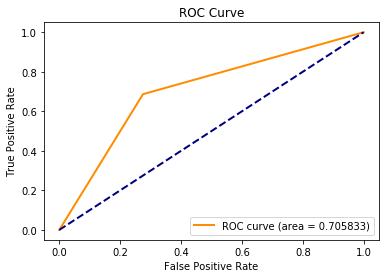

In [172]:
# ROC + AUC
# y_predict_proba = model.predict_proba(X_test)
probabilities = np.array(predicted_test)
fpr, tpr, _ = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)
print('-----------------------------------------------------------------------------------------------------------')
print('Roc auc: ', roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Character trigrams

In [173]:
char_trigram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(3, 3))
X_train_char_trigrams = char_trigram_vectorizer.fit_transform(X_train)
X_test_char_trigrams = char_trigram_vectorizer.fit_transform(X_test)

In [174]:
# Fit the LSI model and perform dimensionality reduction
X_train_char_trigrams_reduced = svd.fit_transform(X_train_char_trigrams)
X_test_char_trigrams_reduced = svd.fit_transform(X_test_char_trigrams)

In [175]:
# 4. Support Vector Machine
svm_clf.fit(X_train_char_trigrams_reduced, y_train)

predicted_test = svm_clf.predict(X_test_char_trigrams_reduced)
predicted_train = svm_clf.predict(X_train_char_trigrams_reduced)

print('========== Character 3-grams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== Character 3-grams (SVM) ==========
The F-1 score for test query is 0.5192217299197985
Training accuracy of SVM model is 0.741593525589878
Test accuracy of SVM model is 0.5727083333333334



Character 4-grams

In [34]:
char_4gram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(4, 4))
X_train_char_4grams = char_4gram_vectorizer.fit_transform(X_train)
X_test_char_4grams = char_4gram_vectorizer.fit_transform(X_test)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [1, 1, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [4, 1, 1, ..., 0, 0, 0],
       [2, 0, 4, ..., 0, 0, 0]])

In [37]:
# Fit the LSI model and perform dimensionality reduction
X_train_char_4grams_reduced = svd.fit_transform(X_train_char_4grams)
X_test_char_4grams_reduced = svd.fit_transform(X_test_char_4grams)

In [38]:
# 4. Support Vector Machine
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train_char_4grams_reduced, y_train)

predicted_test = svm_clf.predict(X_test_char_4grams_reduced)
predicted_train = svm_clf.predict(X_train_char_4grams_reduced)

print('========== Character 4-grams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== Support Vector Machine ==========
The F-1 score for test query is 0.5014245014245013
Training accuracy of SVM model is 0.7282571526273794
Test accuracy of SVM model is 0.5625



Character 5-grams

In [39]:
char_5gram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(5, 5))
X_train_char_5grams = char_5gram_vectorizer.fit_transform(X_train)
X_test_char_5grams = char_5gram_vectorizer.fit_transform(X_test)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [1, 1, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [4, 1, 1, ..., 0, 0, 0],
       [2, 0, 4, ..., 0, 0, 0]])

In [40]:
# Fit the LSI model and perform dimensionality reduction
X_train_char_5grams_reduced = svd.fit_transform(X_train_char_5grams)
X_test_char_5grams_reduced = svd.fit_transform(X_test_char_5grams)

In [41]:
# 4. Support Vector Machine
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train_char_5grams_reduced, y_train)

predicted_test = svm_clf.predict(X_test_char_5grams_reduced)
predicted_train = svm_clf.predict(X_train_char_5grams_reduced)

print('========== Character 5-grams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== Character 5-grams (SVM) ==========
The F-1 score for test query is 0.46976818940786447
Training accuracy of SVM model is 0.7140658839621566
Test accuracy of SVM model is 0.5489583333333333



Character 6-grams

In [42]:
char_6gram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(6, 6))
X_train_char_6grams = char_6gram_vectorizer.fit_transform(X_train)
X_test_char_6grams = char_6gram_vectorizer.fit_transform(X_test)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [1, 1, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [4, 1, 1, ..., 0, 0, 0],
       [2, 0, 4, ..., 0, 0, 0]])

In [43]:
# Fit the LSI model and perform dimensionality reduction
X_train_char_6grams_reduced = svd.fit_transform(X_train_char_6grams)
X_test_char_6grams_reduced = svd.fit_transform(X_test_char_6grams)

In [44]:
# 4. Support Vector Machine
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train_char_6grams_reduced, y_train)

predicted_test = svm_clf.predict(X_test_char_6grams_reduced)
predicted_train = svm_clf.predict(X_train_char_6grams_reduced)

print('========== Character 6-grams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== Character 5-grams (SVM) ==========
The F-1 score for test query is 0.46976818940786447
Training accuracy of SVM model is 0.7140658839621566
Test accuracy of SVM model is 0.5489583333333333



Character 7-grams

In [45]:
char_7gram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(7, 7))
X_train_char_7grams = char_7gram_vectorizer.fit_transform(X_train)
X_test_char_7grams = char_7gram_vectorizer.fit_transform(X_test)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [1, 1, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [4, 1, 1, ..., 0, 0, 0],
       [2, 0, 4, ..., 0, 0, 0]])

In [46]:
# Fit the LSI model and perform dimensionality reduction
X_train_char_7grams_reduced = svd.fit_transform(X_train_char_7grams)
X_test_char_7grams_reduced = svd.fit_transform(X_test_char_7grams)

In [ ]:
# 4. Support Vector Machine
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train_char_7grams_reduced, y_train)

predicted_test = svm_clf.predict(X_test_char_7grams_reduced)
predicted_train = svm_clf.predict(X_train_char_7grams_reduced)

print('========== Character 7-grams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

Character 8-grams

In [48]:
char_8gram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(8, 8))
X_train_char_8grams = char_8gram_vectorizer.fit_transform(X_train)
X_test_char_8grams = char_8gram_vectorizer.fit_transform(X_test)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [1, 1, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [4, 1, 1, ..., 0, 0, 0],
       [2, 0, 4, ..., 0, 0, 0]])

In [49]:
# Fit the LSI model and perform dimensionality reduction
X_train_char_8grams_reduced = svd.fit_transform(X_train_char_8grams)
X_test_char_8grams_reduced = svd.fit_transform(X_test_char_8grams)

In [50]:
# Support Vector Machine
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train_char_8grams_reduced, y_train)

predicted_test = svm_clf.predict(X_test_char_8grams_reduced)
predicted_train = svm_clf.predict(X_train_char_8grams_reduced)

print('========== Character 8-grams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== Character 5-grams (SVM) ==========
The F-1 score for test query is 0.46976818940786447
Training accuracy of SVM model is 0.7140658839621566
Test accuracy of SVM model is 0.5489583333333333



Word unigrams

In [55]:
word_unigram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
X_train_word_unigrams = word_unigram_vectorizer.fit_transform(X_train)
X_test_word_unigrams = word_unigram_vectorizer.fit_transform(X_test)

In [56]:
# Fit the LSI model and perform dimensionality reduction
X_train_word_unigrams_reduced = svd.fit_transform(X_train_word_unigrams)
X_test_word_unigrams_reduced = svd.fit_transform(X_test_word_unigrams)

In [57]:
# Support Vector Machine
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train_word_unigrams_reduced, y_train)

predicted_test = svm_clf.predict(X_test_word_unigrams_reduced)
predicted_train = svm_clf.predict(X_train_word_unigrams_reduced)

print('========== Word unigrams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== Character 5-grams (SVM) ==========
The F-1 score for test query is 0.6314399701297755
Training accuracy of SVM model is 0.7387438732474638
Test accuracy of SVM model is 0.63875



Word bigrams

In [58]:
word_bigram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X_train_word_bigrams = word_bigram_vectorizer.fit_transform(X_train)
X_test_word_bigrams = word_bigram_vectorizer.fit_transform(X_test)

In [59]:
# Fit the LSI model and perform dimensionality reduction
X_train_word_bigrams_reduced = svd.fit_transform(X_train_word_bigrams)
X_test_word_bigrams_reduced = svd.fit_transform(X_test_word_bigrams)

In [60]:
# Support Vector Machine
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train_word_bigrams_reduced, y_train)

predicted_test = svm_clf.predict(X_test_word_bigrams_reduced)
predicted_train = svm_clf.predict(X_train_word_bigrams_reduced)

print('========== Word bigrams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== Character 5-grams (SVM) ==========
The F-1 score for test query is 0.6314399701297755
Training accuracy of SVM model is 0.7387438732474638
Test accuracy of SVM model is 0.63875



Word trigrams

In [139]:
word_trigram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(3, 3))
X_train_word_trigrams = word_trigram_vectorizer.fit_transform(X_train)
X_test_word_trigrams = word_trigram_vectorizer.fit_transform(X_test)

In [140]:
# Fit the LSI model and perform dimensionality reduction
X_train_word_trigrams_reduced = svd.fit_transform(X_train_word_trigrams)
X_test_word_trigrams_reduced = svd.fit_transform(X_test_word_trigrams)

In [141]:
# Support Vector Machine
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train_word_trigrams, y_train)

predicted_test = svm_clf.predict(X_test_word_trigrams)
predicted_train = svm_clf.predict(X_train_word_trigrams)

print('========== Word trigrams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

ValueError: X.shape[1] = 82789 should be equal to 280703, the number of features at training time

In [111]:
from toolz import itertoolz, compose
from toolz.curried import map as cmap, sliding_window, pluck
from sklearn.feature_extraction.text import CountVectorizer

In [119]:
class OneSkipBigramVectorizer(CountVectorizer):
    def build_analyzer(self):    
        preprocess = self.build_preprocessor()
        stop_words = self.get_stop_words()
        tokenize = self.build_tokenizer()
        return lambda doc: self._word_skip_grams(
                compose(tokenize, preprocess, self.decode)(doc),
                stop_words)

    def _word_skip_grams(self, tokens, stop_words=None):
        # handle stop words
        if stop_words is not None:
            tokens = [w for w in tokens if w not in stop_words]

        return compose(cmap(' '.join), pluck([0, 2]), sliding_window(3))(tokens)

In [120]:
class TwoSkipBigramVectorizer(CountVectorizer):
    def build_analyzer(self):    
        preprocess = self.build_preprocessor()
        stop_words = self.get_stop_words()
        tokenize = self.build_tokenizer()
        return lambda doc: self._word_skip_grams(
                compose(tokenize, preprocess, self.decode)(doc),
                stop_words)

    def _word_skip_grams(self, tokens, stop_words=None):
        # handle stop words
        if stop_words is not None:
            tokens = [w for w in tokens if w not in stop_words]

        return compose(cmap(' '.join), pluck([0, 3]), sliding_window(4))(tokens)

In [121]:
class ThreeSkipBigramVectorizer(CountVectorizer):
    def build_analyzer(self):    
        preprocess = self.build_preprocessor()
        stop_words = self.get_stop_words()
        tokenize = self.build_tokenizer()
        return lambda doc: self._word_skip_grams(
                compose(tokenize, preprocess, self.decode)(doc),
                stop_words)

    def _word_skip_grams(self, tokens, stop_words=None):
        # handle stop words
        if stop_words is not None:
            tokens = [w for w in tokens if w not in stop_words]

        return compose(cmap(' '.join), pluck([0, 4]), sliding_window(5))(tokens)

1-skip bigrams

In [130]:
one_skip_bigram_vectorizer = OneSkipBigramVectorizer()
# vect.fit(X_train)
X_train_one_skip_bigrams = one_skip_bigram_vectorizer.fit_transform(X_train)
X_test_one_skip_bigrams = one_skip_bigram_vectorizer.fit_transform(X_test)

In [131]:
# Fit the LSI model and perform dimensionality reduction
X_train_one_skip_bigrams_reduced = svd.fit_transform(X_train_one_skip_bigrams)
X_test_one_skip_bigrams_reduced = svd.fit_transform(X_test_one_skip_bigrams)

In [132]:
# Support Vector Machine
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train_one_skip_bigrams_reduced, y_train)

predicted_test = svm_clf.predict(X_test_one_skip_bigrams_reduced)
predicted_train = svm_clf.predict(X_train_one_skip_bigrams_reduced)

print('========== 1-skip bigrams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== Word trigrams (SVM) ==========
The F-1 score for test query is 0.5604783092032326
Training accuracy of SVM model is 0.7071127322466659
Test accuracy of SVM model is 0.5864583333333333



2-skip bigrams

In [133]:
two_skip_bigram_vectorizer = TwoSkipBigramVectorizer()
# vect.fit(X_train)
X_train_two_skip_bigrams = two_skip_bigram_vectorizer.fit_transform(X_train)
X_test_two_skip_bigrams = two_skip_bigram_vectorizer.fit_transform(X_test)

In [134]:
# Fit the LSI model and perform dimensionality reduction
X_train_two_skip_bigrams_reduced = svd.fit_transform(X_train_two_skip_bigrams)
X_test_two_skip_bigrams_reduced = svd.fit_transform(X_test_two_skip_bigrams)

In [135]:
# Support Vector Machine
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train_two_skip_bigrams_reduced, y_train)

predicted_test = svm_clf.predict(X_test_two_skip_bigrams_reduced)
predicted_train = svm_clf.predict(X_train_two_skip_bigrams_reduced)

print('========== 2-skip bigrams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== Word trigrams (SVM) ==========
The F-1 score for test query is 0.5810189134250331
Training accuracy of SVM model is 0.7059728713097002
Test accuracy of SVM model is 0.5975



3-skip bigrams

In [136]:
three_skip_bigram_vectorizer = ThreeSkipBigramVectorizer()
# vect.fit(X_train)
X_train_three_skip_bigrams = three_skip_bigram_vectorizer.fit_transform(X_train)
X_test_three_skip_bigrams = three_skip_bigram_vectorizer.fit_transform(X_test)

In [137]:
# Fit the LSI model and perform dimensionality reduction
X_train_three_skip_bigrams_reduced = svd.fit_transform(X_train_three_skip_bigrams)
X_test_three_skip_bigrams_reduced = svd.fit_transform(X_test_three_skip_bigrams)

In [138]:
# Support Vector Machine
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train_three_skip_bigrams_reduced, y_train)

predicted_test = svm_clf.predict(X_test_three_skip_bigrams_reduced)
predicted_train = svm_clf.predict(X_train_three_skip_bigrams_reduced)

print('========== 3-skip bigrams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== Word trigrams (SVM) ==========
The F-1 score for test query is 0.5832349984703467
Training accuracy of SVM model is 0.7022113302177134
Test accuracy of SVM model is 0.5964583333333333



All features

In [150]:
all_features_vectorizer = CountVectorizer(analyzer='word', ngram_range=(3, 3))
X_train_all_features = all_features_vectorizer.fit_transform(X_train)
X_test_all_features = all_features_vectorizer.fit_transform(X_test)

In [151]:
# Fit the LSI model and perform dimensionality reduction
X_train_all_features_reduced = svd.fit_transform(X_train_all_features)
X_test_all_features_reduced = svd.fit_transform(X_test_all_features)

In [154]:
X_train_all_features_reduced.shape[1]

80

In [155]:
# Support Vector Machine
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train_all_features_reduced, y_train)

predicted_test = svm_clf.predict(X_test_all_features_reduced)
predicted_train = svm_clf.predict(X_train_all_features_reduced)

print('========== Word trigrams (SVM) ==========')
print('The F-1 score for test query is ' + str(metrics.f1_score(y_test, predicted_test, average = 'macro')))
print('Training accuracy of SVM model is ' + str(np.mean(predicted_train == y_train)))
print('Test accuracy of SVM model is ' + str(np.mean(predicted_test == y_test)))
print('')

========== Word trigrams (SVM) ==========
The F-1 score for test query is 0.5124197211202561
Training accuracy of SVM model is 0.6191724609597629
Test accuracy of SVM model is 0.5604166666666667

